# Polscope with phase forward simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 256                 # number of pixel in y dimension
M           = 256                 # number of pixel in x dimension
mag         = 40                  # magnification
ps          = 6.5/mag             # effective pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 0.55                # objective NA
NA_illu     = 0.4                 # illumination NA (condenser)
NA_illu_in  = 0.3                 # illumination NA (phase contrast inner ring)
z_defocus   = (np.r_[:5]-2)*1.757 # a set of defocus plane
chi         = 0.03*2*np.pi           # swing of Polscope analyzer


### Sample creation

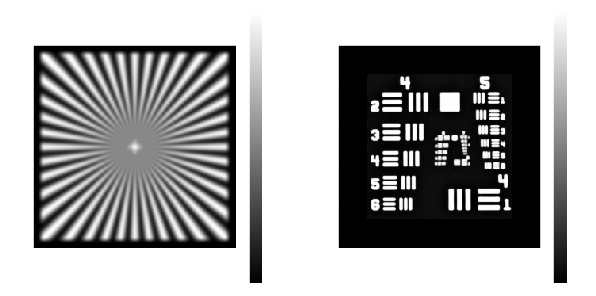

In [3]:

# generate Siemens star target

star, theta = wo.genStarTarget(N,M)


# Load res_target
res_target = np.double(plt.imread('resolution.jpg'))
res_target = res_target[322:506,357:541,1]
res_target = np.pad(res_target/np.max(res_target),36,mode='constant')


wo.plot_multicolumn(np.array([star, res_target]), num_col=2, size=5)

In [4]:
0.03/2/np.pi*532

2.5401128917466496

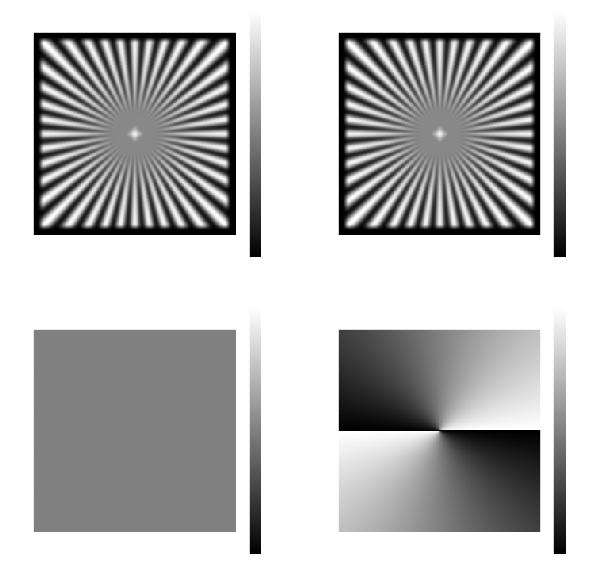

In [5]:
# Physical value assignment

phase_value = 1

phi_s = star*(phase_value + 0.03)
phi_f = star*(phase_value - 0.03)

# mu_s = res_target/5
mu_s = np.zeros((N,M))
mu_f = mu_s.copy()

t_eigen = np.zeros((2, N, M), complex)

t_eigen[0] = np.exp(-mu_s + 1j*phi_s)
t_eigen[1] = np.exp(-mu_f + 1j*phi_f)

sa = theta%np.pi

wo.plot_multicolumn(np.array([phi_s, phi_f, mu_s, sa]), \
                     num_col=2, size=5, set_title=True, \
                     titles=['Phase (slow)', 'Phase (fast)', 'absorption', 'slow axis'])



### Partially coherent forward model

In [6]:
# Microscope object generation

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                cali=False, bg_option='global', ph_contrast=False, NA_illu_in=NA_illu_in)


In [7]:
I_meas, Stokes_out = setup.simulate_waveorder_measurements(t_eigen, sa)

Number of sources considered (100 / 3077)
Number of sources considered (200 / 3077)
Number of sources considered (300 / 3077)
Number of sources considered (400 / 3077)
Number of sources considered (500 / 3077)
Number of sources considered (600 / 3077)
Number of sources considered (700 / 3077)
Number of sources considered (800 / 3077)
Number of sources considered (900 / 3077)
Number of sources considered (1000 / 3077)
Number of sources considered (1100 / 3077)
Number of sources considered (1200 / 3077)
Number of sources considered (1300 / 3077)
Number of sources considered (1400 / 3077)
Number of sources considered (1500 / 3077)
Number of sources considered (1600 / 3077)
Number of sources considered (1700 / 3077)
Number of sources considered (1800 / 3077)
Number of sources considered (1900 / 3077)
Number of sources considered (2000 / 3077)
Number of sources considered (2100 / 3077)
Number of sources considered (2200 / 3077)
Number of sources considered (2300 / 3077)
Number of sources co

In [8]:
wo.parallel_4D_viewer(np.transpose(I_meas,(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [9]:
# Add noise to the measurement

photon_count = 14000
ext_ratio    = 180
const_bg     = photon_count/(0.5*(1-np.cos(chi)))/ext_ratio

I_meas_noise = np.random.poisson(I_meas/np.max(I_meas) * photon_count + const_bg)


In [10]:
wo.parallel_4D_viewer(np.transpose(I_meas_noise,(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [11]:
# Save simulations

f = open('simulation_data_phase_1_noise.pckl', 'wb')
pickle.dump((I_meas_noise, Stokes_out, lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi), f)
f.close()